### House_price_prediction

데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?  

제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?  

다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가? 

(가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널 앙상블 기법활용)

### 1. 데이터 탐색

#### 1.1 문제 정의  
이번 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제 입니다.

평가로는 RMSE를 사용합니다.

비슷한 대회로는 데이콘에서 열린 직방 모델링 대회와 캐글에서 열린 House Prices: Advanced Regression Techniques가 있습니다

In [1]:
import os
from os.path import join
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [3]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)


train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


훈련과 평가 데이터의 크기는 15000과 6500으로 적은편이고 비율은 5:2 로 심하게 불균등하지는 않습니다. 변수의 갯수가 20개로 적은편이서 좋은 피쳐를 만들어 내는것이 모델성능에 관건으로 생각됩니다.

#### 1.2 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 타겟 변수인 집의 가격  
bedrooms : 침실의 수  
bathrooms : 침실당 화장실 개수  
sqft_living : 주거 공간의 평방 피트  
sqft_lot : 부지의 평방 피트  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트  
sqft_basement : 지하실의 평방 피트  
yr_built : 집을 지은 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  

In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* date의 경우 yyyy-mm-dd + T000000의 형태로 저희가 필요한 부분은 앞의 8자리 입니다.
* bathrooms의 경우 소숫점의 값이 보이는데, 이는 미국의 기준에 따른 것입니다. 자세한 내용은 아래 부분에 나옵니다.
* yr_renovated의 경우 0의 값이 보이는데, 0년도에 재건축이 되었다는 의미가 아니라 재건축을 하지 않았다는 의미입니다.
* sqft_living 과 sqft_living15처럼 비슷한 값이 보입니다. 둘은 15년도를 기준으로 크기 계산의 기준에 따라 다른 값을 보입니다. 둘의 차이가 꽤 큰 부분도 있어서 이를 잘 활용해야 할 것 같습니다.
head를 통해서는 이 정도로 가볍게 변수를 이해해보고 하나하나 변수를 살펴보면서 전처리해야 할 부분과 피쳐 엔지니어링을 할 아이디어를 고민해보겠습니다.

#### 1.3 변수 시각화 ( 목적변수 )
목적변수 price의 경우 집을 구매한 시점 의 가격입니다. 이 말은 현재의 가격을 반영하는게 아니라는 말과 같습니다. 집을 산 이후 리모델링을 통해 집을 고쳤어도 집의 가격에는 영향을 주지 못합니다.


In [5]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

목적변수의 경우 min과 max의 차이가 크고, std가 굉장히 큰 편입니다. 아래의 그림을 보면 더 명확하겠지만 왼쪽으로 분포가 굉장히 치우친 것을 알 수 있습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

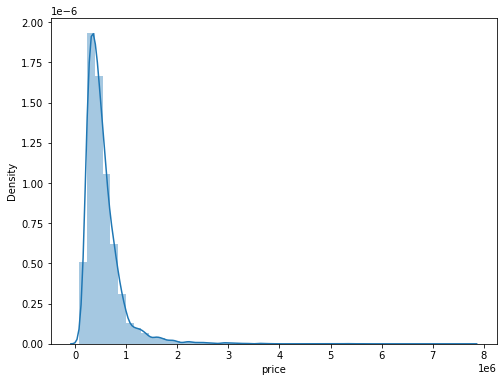

In [6]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [7]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


* 왜도 : 오른쪽 꼬리가 길수록 값이 더 큽니다.
* 첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 간주 할 수 있습니다.

위의 목적변수의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. 저는 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주겠습니다.

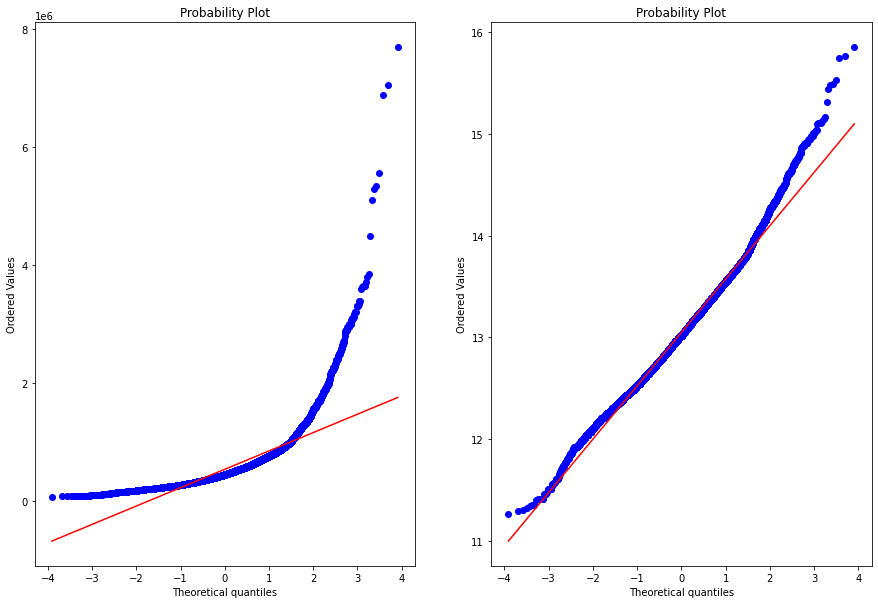

In [8]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

log를 취해주면 기존보다 더 정규성을 가지는 것을 확인할 수 있습니다

<AxesSubplot:xlabel='price', ylabel='Density'>

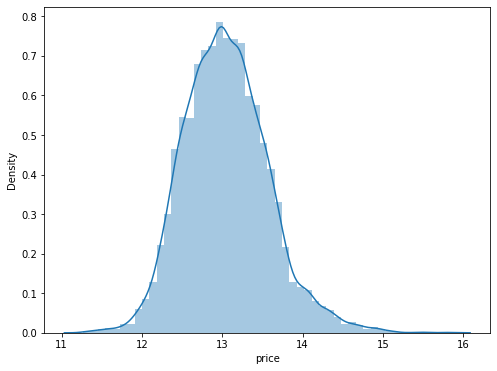

In [9]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

#### 1.3 변수시각화 ( 반응변수 )    
* 피어슨 상관관계 : 연속형 변수에 사용  
* 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용 
  
아래는 목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다. 전부 보는 것이 아니라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 하겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

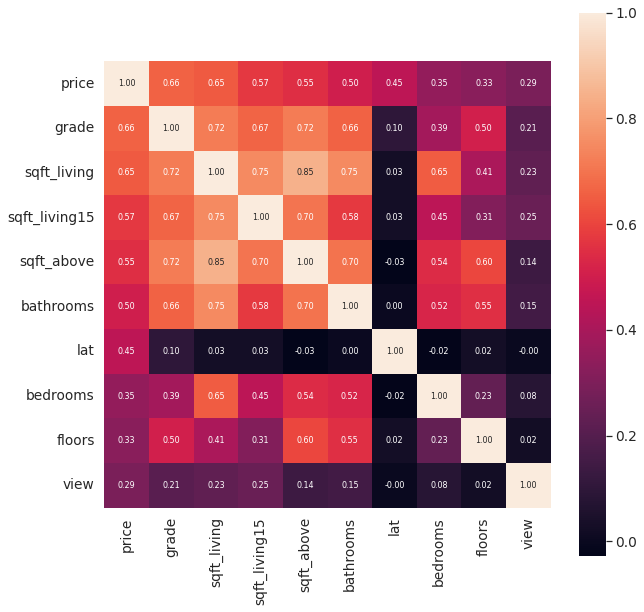

In [10]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

목적변수와 상관도가 높은 변수는 집의 등급 - 주거공간의 크기 - 전체 크기순이고 재미있게 lat이라는 위도 값이 들어있습니다. 위도가 증가함에 따라 가격이 왜 증가하는지 ? 이것을 어떻게 활용할 수 있는지는 좀 더 탐색이 필요해보입니다.
  
위에서 lat의 경우 price와 상관성이 높은 것을 볼 수 있었습니다  
위의 지역은 시애틀인데 시애틀은 북쪽으로 갈 수록 살기 좋은 집들이 많다고 합니다.

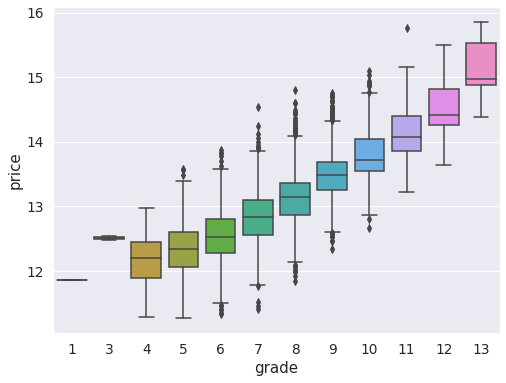

In [11]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다.

집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만

* 등급 3의 경우 값이 큰 이유
* 등급 7,8,9에서 이상치가 많은 이유
* 등급 8과 11에서 차이가 큰 이상치가 나타나는 이유

위의 3가지는 좀 더 자세히 살펴봐야 합니다.

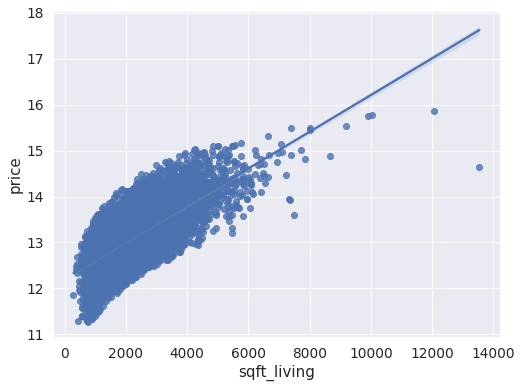

In [12]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

sqlf_living / sqlf_lot
(주거 평방 피트 / 부지 평방 피트)

1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다.

즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.

전반적으로 선형성을 보이지만 가격이 14~15사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)으로 생각되어집니다. 제거할지 말지는 저 값을 확인해보고 결정하겠습니다.

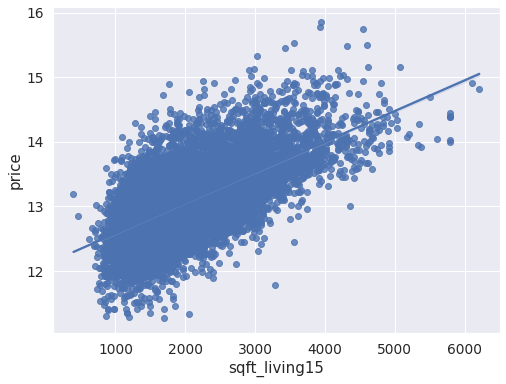

In [13]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다. 아무래도 재건축으로 인한 영향일 것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 FE이 필요해 보입니다.

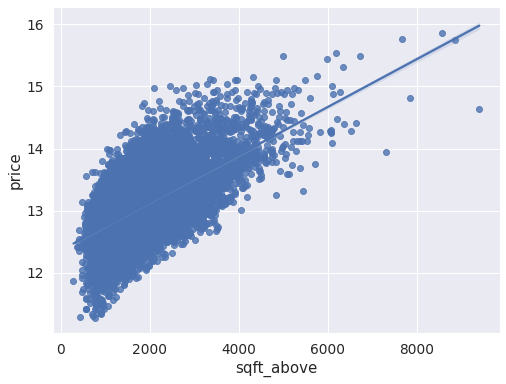

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

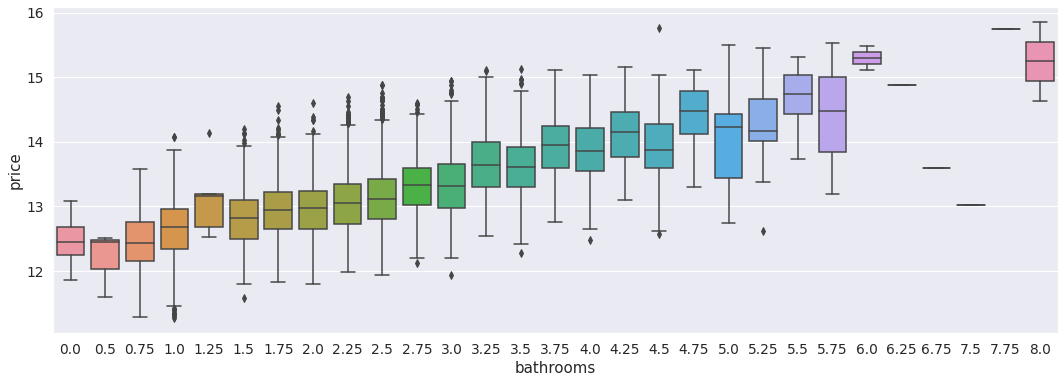

In [15]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다.

* 0.5 : 세면대, 화장실
* 0.75 : 세면대, 화장실, 샤워실
* 1 : 세면대, 화장실, 샤워실, 욕조

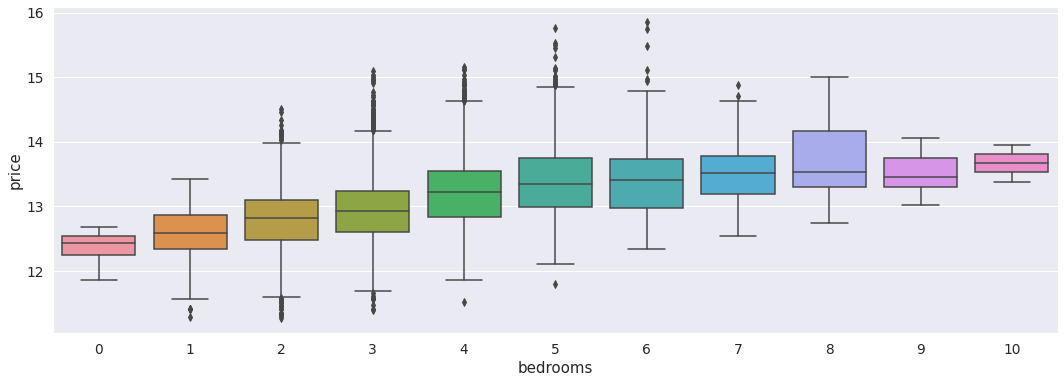

In [16]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

방의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 띄는것을 볼 수 있습니다. 그리고 방의 갯수가 2~6의 경우 방이 적음에도 값이 큰 값들이 많습니다. 이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.

### 2. 데이터 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다. 

### 2.1 이상치 제거
* sqft_living, grade, bedrooms
위에서 중요한 변수들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다.

#### 2.1.1 sqft_living

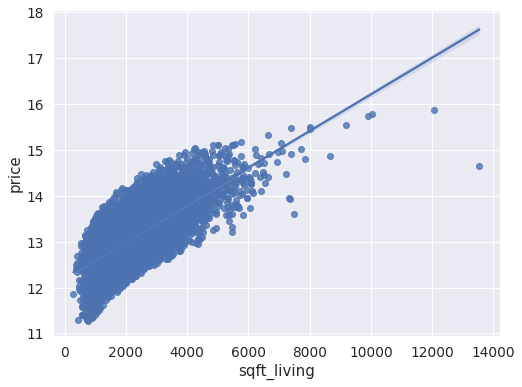

In [17]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

df_train.loc[df_train['sqft_living'] > 13000]

위의 값을 봤을 때, 다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다. 추가적으로 price와 상관성이 높은 grade와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 하겠습니다.

In [18]:
df_train = df_train.loc[df_train['id']!=8990]

#### 2.1.2 grade

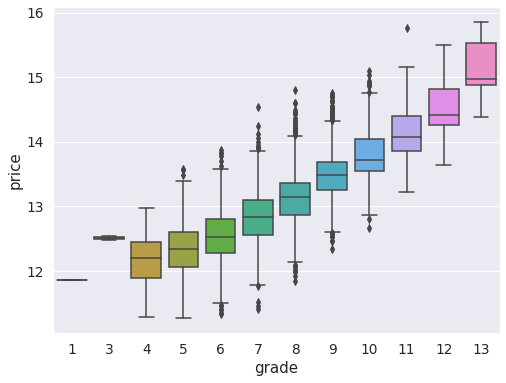

In [19]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [20]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.

In [21]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [22]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 3값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.

In [23]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

#### 2.1.3 bedrooms

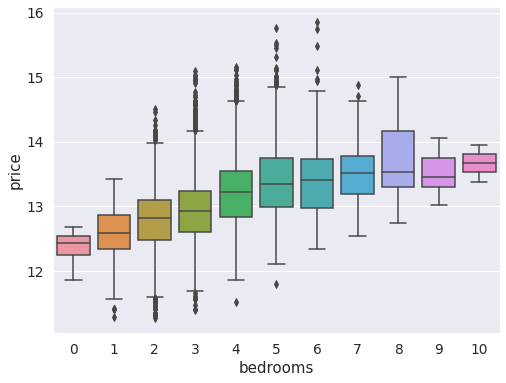

In [24]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

침실의 수를 보면 위에서 한 얘기와 마찬가지로 median이 양의 상관관계를 띄고 있습니다. 그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있습니다. 가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.

#### 2.2 정규화

In [25]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

#### 2.3 변수 수정

In [26]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

### 3. 변수 생성

In [27]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [28]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

아래는 집값 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것 입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다 !!!

In [29]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

### 4. 모델링  

#### 4.1 단순 선형회귀

In [30]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [31]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.746e+06
Date:                Sat, 22 Jan 2022   Prob (F-statistic):                        0.00
Time:                        20:41:47   Log-Likelihood:                         -7.7075
No. Observations:               15029   AIC:                                      65.42
Df Residuals:                   15004   BIC:                                      255.9
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

모델의 설명력을 보면 1로 굉장히 높지만, 각각의 변수들 중에서는 p-value가 높은 값들이 있음을 확인할 수 있습니다. 그러한 이유를 생각해보면 FE해서 나온 파생변수들은 기존의 변수와 연관되어있고 sqft_로 시작하는 변수들끼리의 상관성등이 있어서 다중공선성의 문제를 가지기 때문입니다. 실제로 다중공선성을 체크하기 위해 vif를 이용한 확인을 하면

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.294167e+06
1,date,4.284045e+06
18,long,2.057338e+06
17,lat,2.441371e+05


보통의 경우 10 이상이면 다중공선성이 존재한다고 말하는데, 위의 식에서는 waterfront, view, sqft_lot15, is_renovated 4가지 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있습니다.

이를 해결하기 위한 방안으로는

* 다중공선성에 robust한 트리모델을 사용하는 방법
* 변수제거 및 FE, 변환등을 통한 대체
* 관측값을 늘려 표본의 크기를 증가

하지만 마지막 3의 방안은 실현이 불가능하고 선형회귀를 사용할거면 2를 최대한 활용하고, 그렇지 않을 경우에는 1번 방안을 사용하면 됩니다.

#### 4.2 LightGBM

In [33]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.140092	valid_1's rmse: 0.156519
[1000]	training's rmse: 0.121221	valid_1's rmse: 0.153075
[1500]	training's rmse: 0.108602	valid_1's rmse: 0.152351
Early stopping, best iteration is:
[1505]	training's rmse: 0.108489	valid_1's rmse: 0.152332
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139304	valid_1's rmse: 0.159886
[1000]	training's rmse: 0.120849	valid_1's rmse: 0.155975
[1500]	training's rmse: 0.108283	valid_1's rmse: 0.154827
[2000]	training's rmse: 0.0982398	valid_1's rmse: 0.154545
Early stopping, best iteration is:
[2130]	training's rmse: 0.0959464	valid_1's rmse: 0.154486
[LightGBM] [Warning] min_data_in_leaf is

In [34]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


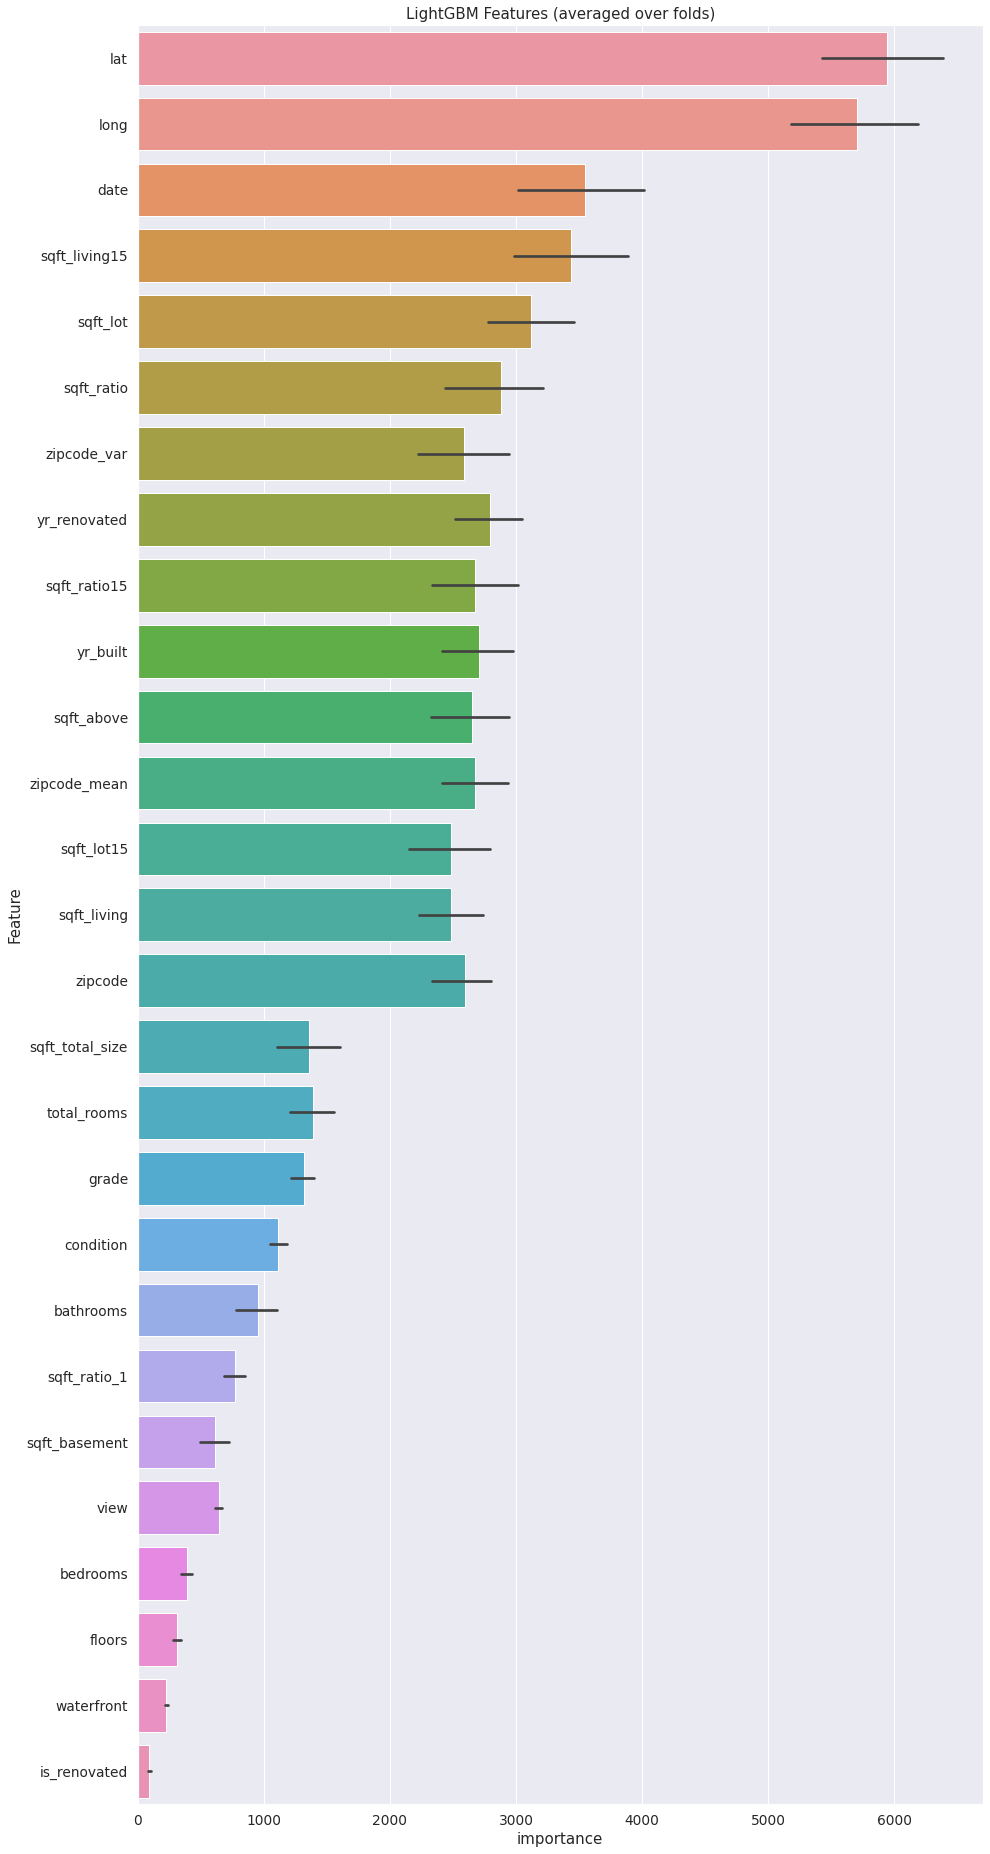

In [35]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## Ensemble

In [36]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


In [37]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135526	valid_1's rmse: 134961
[1000]	training's rmse: 110615	valid_1's rmse: 123725
[1500]	training's rmse: 99530.7	valid_1's rmse: 121525
[2000]	training's rmse: 91409.6	valid_1's rmse: 121040
Early stopping, best iteration is:
[2067]	training's rmse: 90494.9	valid_1's rmse: 120880
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135171	valid_1's rmse: 134731
[1000]	training's rmse: 110537	valid_1's rmse: 117358
[1500]	training's rmse: 100159	valid_1's rmse: 114319
Early stopping, best iteration is:
[1845]	training's rmse: 94511.6	valid_1's rmse: 113898
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will

In [38]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124996.83409814813


In [39]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[20:43:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:43:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:43:33] WARNING: ../src/objective/regression_obj.cu:171:

In [40]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115824.77593122724


In [41]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[20:46:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:50] WARNING: ../src/objective/regression_obj.cu:171:

In [42]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115824.77593122724


In [43]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [44]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [45]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission.csv",index=False)

### Ensemble Score: 108286.01371
    
### Reference: https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12